# Air Pollution Forecasting - Temp

In [80]:
import pandas as pd
import numpy as np

In [81]:
df = pd.read_csv("../data/data_imputed_2.csv")

In [82]:
import matplotlib.pyplot as plt

In [83]:
df.head()

,timestamp_local,temp,city_name,country_code,aqi,co,no2,o3,pm10,pm25,so2
0,01/02/2022 0:00,12.6,Gujrāt,PK,385,1339.8,76.0,10.7,491.7,347.67,238.0
1,01/02/2022 1:00,11.5,Gujrāt,PK,404,1437.6,76.0,9.3,508.3,359.33,268.0
2,01/02/2022 2:00,11.9,Gujrāt,PK,421,1535.5,76.0,8.0,525.0,371.00,298.0
3,01/02/2022 3:00,12.2,Gujrāt,PK,425,1659.0,68.3,5.3,529.3,374.00,275.7
4,01/02/2022 4:00,11.9,Gujrāt,PK,430,1782.5,60.7,2.7,533.7,377.00,253.3


In [84]:
data = df[['temp']]

In [85]:
def series_to_supervised(data, n_in = 1, n_out = 1, dropnan = True):
    n_vars = 1 if type(data) is list else data.shape[1]
    
    df = pd.DataFrame(data)
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
            
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
        
    return agg

In [86]:
from sklearn.metrics import mean_absolute_error , mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

In [87]:
values = data.values

values = values.astype('float32')

scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [90]:
# converting the dataset as supervised learning
reframed = series_to_supervised(scaled, 168, 168)
print(reframed.shape)

(19371, 336)


In [91]:
values = reframed.values

# We train the model on the 1st 3 years and then test on the last year (for now)
n_train_hours = int(365 * 24 * 1.5)

train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D :- (no.of samples, no.of timesteps, no.of features)
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(13140, 1, 335) (13140,) (6231, 1, 335) (6231,)


In [105]:
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, BatchNormalization, Conv2D, ConvLSTM1D, RepeatVector, TimeDistributed, Conv1D, GRU
from tensorflow.keras.models import Sequential

In [114]:
model3 = Sequential()
model3.add(Input(shape=(train_X.shape[1], train_X.shape[2])))
model3.add(GRU(64))
model3.add(Dense(8, 'relu'))
model3.add(Dense(168, 'linear'))
model3.summary()

Model: "sequential_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_1 (GRU)                          │ (None, 64)                  │          76,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 8)                   │             520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 168)                 │           1,512 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 79,024 (308.69 KB)

 Trainable params: 79,024 (308.69 KB)

 Non-trainable params: 0 (0.00 B)

In [115]:
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
# cp3 = ModelCheckpoint('model3/', save_best_only=True)
model3.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [116]:
model3.fit(train_X, train_y, validation_split=0.2, verbose=2, shuffle=False, epochs=10)

Epoch 1/10


InvalidArgumentError: Graph execution error:

Detected at node compile_loss/mean_squared_error/sub defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Hassan\AppData\Local\Programs\Python\Python311\Lib\site-packages\ipykernel_launcher.py", line 18, in <module>

  File "C:\Users\Hassan\AppData\Local\Programs\Python\Python311\Lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance

  File "C:\Users\Hassan\AppData\Local\Programs\Python\Python311\Lib\site-packages\ipykernel\kernelapp.py", line 739, in start

  File "C:\Users\Hassan\AppData\Local\Programs\Python\Python311\Lib\site-packages\tornado\platform\asyncio.py", line 205, in start

  File "C:\Users\Hassan\AppData\Local\Programs\Python\Python311\Lib\asyncio\base_events.py", line 604, in run_forever

  File "C:\Users\Hassan\AppData\Local\Programs\Python\Python311\Lib\asyncio\base_events.py", line 1909, in _run_once

  File "C:\Users\Hassan\AppData\Local\Programs\Python\Python311\Lib\asyncio\events.py", line 80, in _run

  File "C:\Users\Hassan\AppData\Local\Programs\Python\Python311\Lib\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue

  File "C:\Users\Hassan\AppData\Local\Programs\Python\Python311\Lib\site-packages\ipykernel\kernelbase.py", line 534, in process_one

  File "C:\Users\Hassan\AppData\Local\Programs\Python\Python311\Lib\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell

  File "C:\Users\Hassan\AppData\Local\Programs\Python\Python311\Lib\site-packages\ipykernel\ipkernel.py", line 359, in execute_request

  File "C:\Users\Hassan\AppData\Local\Programs\Python\Python311\Lib\site-packages\ipykernel\kernelbase.py", line 778, in execute_request

  File "C:\Users\Hassan\AppData\Local\Programs\Python\Python311\Lib\site-packages\ipykernel\ipkernel.py", line 446, in do_execute

  File "C:\Users\Hassan\AppData\Local\Programs\Python\Python311\Lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell

  File "C:\Users\Hassan\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\interactiveshell.py", line 3075, in run_cell

  File "C:\Users\Hassan\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\interactiveshell.py", line 3130, in _run_cell

  File "C:\Users\Hassan\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner

  File "C:\Users\Hassan\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\interactiveshell.py", line 3334, in run_cell_async

  File "C:\Users\Hassan\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\interactiveshell.py", line 3517, in run_ast_nodes

  File "C:\Users\Hassan\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\interactiveshell.py", line 3577, in run_code

  File "C:\Users\Hassan\AppData\Local\Temp\ipykernel_9748\2137486928.py", line 1, in <module>

  File "C:\Users\Hassan\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "C:\Users\Hassan\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 325, in fit

  File "C:\Users\Hassan\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 118, in one_step_on_iterator

  File "C:\Users\Hassan\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 106, in one_step_on_data

  File "C:\Users\Hassan\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 60, in train_step

  File "C:\Users\Hassan\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\trainer.py", line 322, in compute_loss

  File "C:\Users\Hassan\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\compile_utils.py", line 605, in __call__

  File "C:\Users\Hassan\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\compile_utils.py", line 641, in call

  File "C:\Users\Hassan\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\losses\loss.py", line 42, in __call__

  File "C:\Users\Hassan\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\losses\losses.py", line 22, in call

  File "C:\Users\Hassan\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\losses\losses.py", line 1154, in mean_squared_error

Incompatible shapes: [32] vs. [32,168]
	 [[{{node compile_loss/mean_squared_error/sub}}]] [Op:__inference_one_step_on_iterator_337044]

In [98]:
# train_X.shape[1] 
train_X.shape[0]

13140

In [68]:
model = Sequential()
model.add(Input(shape=(train_X.shape[1], train_X.shape[2])))
# model.add(LSTM(64))
# model.add(Dense(1))
# model.add(Input(shape=(train_X.shape[1], train_X.shape[2])))
# model.add(LSTM(256))
# model.add(Dense(64))
# model.add(Dropout(0.25))
# model.add(BatchNormalization())
# model.add(Dense(1))
model.add(LSTM(100, activation='relu', return_sequences=True))
# model.add(RepeatVector(1))
model.add(LSTM(100, activation='relu', return_sequences=False))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
model.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_15 (LSTM)                       │ (None, 1, 100)              │         107,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_16 (LSTM)                       │ (None, 100)                 │          80,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 188,101 (734.77 KB)

 Trainable params: 188,101 (734.77 KB)

 Non-trainable params: 0 (0.00 B)

In [69]:
history = model.fit(train_X, train_y, epochs=50, batch_size=264, validation_split=0.2, verbose=2, shuffle=False)

Epoch 1/50
40/40 - 3s - 85ms/step - loss: 0.0453 - val_loss: 0.0397
Epoch 2/50
40/40 - 0s - 9ms/step - loss: 0.0129 - val_loss: 0.0363
Epoch 3/50
40/40 - 0s - 9ms/step - loss: 0.0078 - val_loss: 0.0211
Epoch 4/50
40/40 - 0s - 9ms/step - loss: 0.0057 - val_loss: 0.0138
Epoch 5/50
40/40 - 0s - 8ms/step - loss: 0.0049 - val_loss: 0.0080
Epoch 6/50
40/40 - 0s - 9ms/step - loss: 0.0046 - val_loss: 0.0050
Epoch 7/50
40/40 - 0s - 9ms/step - loss: 0.0042 - val_loss: 0.0038
Epoch 8/50
40/40 - 0s - 9ms/step - loss: 0.0038 - val_loss: 0.0038
Epoch 9/50
40/40 - 0s - 9ms/step - loss: 0.0035 - val_loss: 0.0042
Epoch 10/50
40/40 - 0s - 11ms/step - loss: 0.0034 - val_loss: 0.0048
Epoch 11/50
40/40 - 0s - 9ms/step - loss: 0.0032 - val_loss: 0.0052
Epoch 12/50
40/40 - 0s - 8ms/step - loss: 0.0031 - val_loss: 0.0054
Epoch 13/50
40/40 - 0s - 10ms/step - loss: 0.0030 - val_loss: 0.0053
Epoch 14/50
40/40 - 0s - 8ms/step - loss: 0.0029 - val_loss: 0.0051
Epoch 15/50
40/40 - 0s - 9ms/step - loss: 0.0028 - val

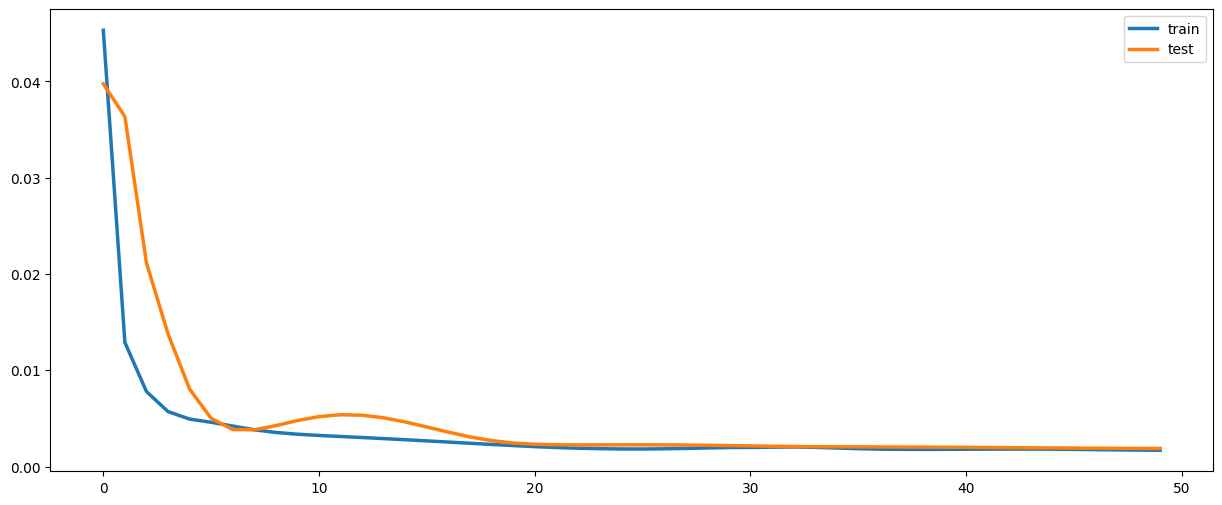

In [70]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,6))
plt.plot(history.history['loss'], label='train', linewidth = 2.5)
plt.plot(history.history['val_loss'], label='test',  linewidth = 2.5)
plt.legend()
plt.show()

In [71]:
testPredict = model.predict(test_X)
print(testPredict.shape)
testPredict = testPredict.ravel()

print(testPredict.shape)

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
(6398, 1)
(6398,)


In [72]:
y_test_true = test[:,1]

In [73]:
poll = np.array(df["aqi"])

meanop = poll.mean()
stdop = poll.std()

y_test_true = y_test_true*stdop + meanop
testPredict = testPredict*stdop + meanop

In [75]:
rmse = np.sqrt(mean_squared_error(test_y, testPredict))
print("Test RMSE ="  ,rmse)

Test RMSE = 181.21182


In [23]:
df

,timestamp_local,temp,city_name,country_code,aqi,co,no2,o3,pm10,pm25,so2
0,01/02/2022 0:00,12.6,Gujrāt,PK,385,1339.8,76.0,10.7,491.7,347.67,238.0
1,01/02/2022 1:00,11.5,Gujrāt,PK,404,1437.6,76.0,9.3,508.3,359.33,268.0
2,01/02/2022 2:00,11.9,Gujrāt,PK,421,1535.5,76.0,8.0,525.0,371.00,298.0
3,01/02/2022 3:00,12.2,Gujrāt,PK,425,1659.0,68.3,5.3,529.3,374.00,275.7
4,01/02/2022 4:00,11.9,Gujrāt,PK,430,1782.5,60.7,2.7,533.7,377.00,253.3
...,...,...,...,...,...,...,...,...,...,...,...
19701,01/05/2024 19:00,24.4,Gujrāt,PK,89,161.5,22.3,102.3,55.0,30.00,21.0
19702,01/05/2024 20:00,23.7,Gujrāt,PK,102,206.6,31.0,79.0,63.0,36.00,25.0
19703,01/05/2024 21:00,23.0,Gujrāt,PK,107,235.4,34.0,65.7,65.3,38.00,26.0
19704,01/05/2024 22:00,21.1,Gujrāt,PK,112,264.2,37.0,52.3,67.7,40.00,27.0


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19706 entries, 0 to 19705
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   timestamp_local  19706 non-null  object 
 1   temp             19706 non-null  float64
 2   city_name        19706 non-null  object 
 3   country_code     19706 non-null  object 
 4   aqi              19706 non-null  int64  
 5   co               19706 non-null  float64
 6   no2              19706 non-null  float64
 7   o3               19706 non-null  float64
 8   pm10             19706 non-null  float64
 9   pm25             19706 non-null  float64
 10  so2              19706 non-null  float64
dtypes: float64(7), int64(1), object(3)
memory usage: 1.7+ MB


In [54]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# Add time-based features
# df['timestamp_local'] = pd.to_datetime(df['timestamp_local'], format="%d/%m/%Y %H:%M")
# df['hour'] = df['timestamp_local'].dt.hour
# df['day_of_week'] = df['timestamp_local'].dt.dayofweek
# df['month'] = df['timestamp_local'].dt.month

# Drop non-numeric columns and set index
# df = df.drop(columns=['hour', 'day_of_week', 'month'])

# Normalize the data using StandardScaler
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)


# Create sequences for LSTM
def create_sequences(data, seq_length, n_steps_ahead):
    xs, ys = [], []
    for i in range(len(data) - seq_length - n_steps_ahead + 1):
        x = data[i:i+seq_length]
        y = data[i+seq_length:i+seq_length+n_steps_ahead]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

SEQ_LENGTH = 168
N_STEPS_AHEAD = 168

X, y = create_sequences(scaled_data, SEQ_LENGTH, N_STEPS_AHEAD)

# Split the data into training and testing sets
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Build the LSTM model
model = Sequential()
model.add(LSTM(128, activation='relu', input_shape=(SEQ_LENGTH, X.shape[2]), return_sequences=True))
# model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(64, activation='relu', return_sequences=True)))
# model.add(Dropout(0.3))
model.add(LSTM(32, activation='relu'))
# model.add(Dropout(0.3))
model.add(Dense(N_STEPS_AHEAD * X.shape[2]))  # Output layer to match the shape of the prediction
model.add(tf.keras.layers.Reshape((N_STEPS_AHEAD, X.shape[2])))  # Reshape to match the expected output shape

model.compile(optimizer=Adam(learning_rate=0.000001), loss='mse')

# Add early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5)

# Train the model
history = model.fit(X_train, y_train, epochs=500, batch_size=32, validation_split=0.2, verbose=1, callbacks=[early_stopping, reduce_lr])

# Evaluate the model
# loss = model.evaluate(X_test, y_test, verbose=1)
# print(f'Test Loss: {loss}')

# Make predictions
y_pred = model.predict(X_test)

# Inverse transform the predictions
y_pred_inv = scaler.inverse_transform(y_pred.reshape(-1, X.shape[2]))
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, X.shape[2]))

print(f'Predictions: {y_pred_inv}')
print(f'Actual Values: {y_test_inv}')

C:\Users\Hassan\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/500
388/388 ━━━━━━━━━━━━━━━━━━━━ 131s 321ms/step - loss: 0.0875 - val_loss: 0.0699 - learning_rate: 1.0000e-06
Epoch 2/500
388/388 ━━━━━━━━━━━━━━━━━━━━ 141s 318ms/step - loss: 0.0867 - val_loss: 0.0697 - learning_rate: 1.0000e-06
Epoch 3/500
388/388 ━━━━━━━━━━━━━━━━━━━━ 123s 318ms/step - loss: 0.0866 - val_loss: 0.0695 - learning_rate: 1.0000e-06
Epoch 4/500
388/388 ━━━━━━━━━━━━━━━━━━━━ 124s 320ms/step - loss: 0.0870 - val_loss: 0.0692 - learning_rate: 1.0000e-06
Epoch 5/500
388/388 ━━━━━━━━━━━━━━━━━━━━ 127s 329ms/step - loss: 0.0858 - val_loss: 0.0688 - learning_rate: 1.0000e-06
Epoch 6/500
388/388 ━━━━━━━━━━━━━━━━━━━━ 128s 330ms/step - loss: 0.0855 - val_loss: 0.0683 - learning_rate: 1.0000e-06
Epoch 7/500
388/388 ━━━━━━━━━━━━━━━━━━━━ 123s 316ms/step - loss: 0.0849 - val_loss: 0.0677 - learning_rate: 1.0000e-06
Epoch 8/500
388/388 ━━━━━━━━━━━━━━━━━━━━ 124s 319ms/step - loss: 0.0845 - val_loss: 0.0669 - learning_rate: 1.0000e-06
Epoch 9/500
388/388 ━━━━━━━━━━━━━━━━━━━━ 131s 33

KeyboardInterrupt: 

In [43]:
X.shape[2]

8

In [44]:
y_test_inv[1]

array([ 17.8 , 184.  , 517.7 ,  63.3 ,  18.7 , 120.7 ,  81.33,  58.  ])

In [55]:
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))

In [56]:
rmse

115.7568938202174

In [117]:
# Prepare the data for the LSTM model
def create_dataset(data, time_step=1, forecast_horizon=1):
    X, y = [], []
    for i in range(len(data) - time_step - forecast_horizon):
        X.append(data[i:(i + time_step)])
        y.append(data[(i + time_step):(i + time_step + forecast_horizon)])
    return np.array(X), np.array(y)

In [118]:
df.head()

,timestamp_local,temp,city_name,country_code,aqi,co,no2,o3,pm10,pm25,so2
0,01/02/2022 0:00,12.6,Gujrāt,PK,385,1339.8,76.0,10.7,491.7,347.67,238.0
1,01/02/2022 1:00,11.5,Gujrāt,PK,404,1437.6,76.0,9.3,508.3,359.33,268.0
2,01/02/2022 2:00,11.9,Gujrāt,PK,421,1535.5,76.0,8.0,525.0,371.00,298.0
3,01/02/2022 3:00,12.2,Gujrāt,PK,425,1659.0,68.3,5.3,529.3,374.00,275.7
4,01/02/2022 4:00,11.9,Gujrāt,PK,430,1782.5,60.7,2.7,533.7,377.00,253.3


In [119]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df[['temp']])

In [120]:
# Create dataset with a lookback of 24 hours and a forecast horizon of 12 hours
time_step = 24
forecast_horizon = 168
X, y = create_dataset(scaled_data, time_step, forecast_horizon)

In [121]:
# Split the data into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [122]:
# Reshape the input data to be 3D [samples, time_steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [125]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
# Build the LSTM model
# model = Sequential()
# model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
# model.add(LSTM(50, return_sequences=False))



model = Sequential()
model.add(Input(shape=(time_step, 1)))
model.add(GRU(500))
model.add(Dense(32*forecast_horizon))
model.add(Dropout(0.25))
model.add(BatchNormalization())
# model.add(Dropout(0.2))
model.add(Dense(forecast_horizon))

In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

# Train the model
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, validation_split=0.2, epochs=100, batch_size=100, callbacks=[early_stop])

Model: "sequential_30"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_3 (GRU)                          │ (None, 500)                 │         754,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 5376)                │       2,693,376 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 5376)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 5376)                │          21,504 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 168)                 │         903,336 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,372,716 (16.68 MB)

 Trainable params: 4,361,964 (16.64 MB)

 Non-trainable params: 10,752 (42.00 KB)

Epoch 1/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 50s 392ms/step - loss: 0.1221 - val_loss: 0.0212
Epoch 2/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 82s 387ms/step - loss: 0.0085 - val_loss: 0.0170
Epoch 3/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 81s 381ms/step - loss: 0.0083 - val_loss: 0.0149
Epoch 4/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 83s 385ms/step - loss: 0.0083 - val_loss: 0.0118
Epoch 5/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 81s 377ms/step - loss: 0.0076 - val_loss: 0.0073
Epoch 6/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 47s 379ms/step - loss: 0.0075 - val_loss: 0.0083
Epoch 7/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 49s 390ms/step - loss: 0.0075 - val_loss: 0.0062
Epoch 8/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 49s 393ms/step - loss: 0.0074 - val_loss: 0.0073
Epoch 9/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 80s 379ms/step - loss: 0.0072 - val_loss: 0.0217
Epoch 10/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 82s 378ms/step - loss: 0.0077 - val_loss: 0.0089
Epoch 11/100
113/125 ━━━━━━━━━━━━━━━━━━━━ 4s 350ms/step - loss: 0.0071

In [32]:
# Predict on the test data
predicted = model.predict(X_test)

122/122 ━━━━━━━━━━━━━━━━━━━━ 47s 369ms/step


In [33]:
y_test_reshaped = y_test.reshape((y_test.shape[0] * y_test.shape[1], 1))  # Reshape to 2D array
y_test_inverse = scaler.inverse_transform(y_test_reshaped)
y_test_inverse = y_test_inverse.reshape(y_test.shape)  # Reshape back to original shape

In [34]:
# Flatten the arrays for RMSE calculation
y_test_flat = y_test_inverse.flatten()
predicted_flat = predicted.flatten()

In [35]:
rmse = np.sqrt(mean_squared_error(y_test_flat, predicted_flat))

In [36]:
rmse

17.63367129638695